## Extraction of simple features
Functions to extract ZC zero crossings, SC spectral centroid, SV spectral variance, ST static tempo using librosa (BPM). Restructuring of the data and saving to the hard drive.

Also some data analysis on the features to see if they are seperable for genre classification.

In [10]:
import sys
import os
import numpy as np
import pydub
import pandas as pd
import librosa
import time

In [11]:
# Functions for (simple) feature extraction
# ZC zero crossings
# SC spectral centroid
# SV spectral variance
# ST static tempo using librosa (BPM). 1 number for entire song


def extractZC( data, windowsizeinsamples, windowhopinsamples ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    numbersignchanges = []
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowhopinsamples)
        datasign = np.sign(data[windowstart:windowend])
        datasignderivative = datasign - np.roll(datasign,1)
        numbersignchanges.append(np.count_nonzero(datasignderivative[1:-1]))
    return np.array(numbersignchanges)

def extractSC( data, windowsizeinsamples, windowhopinsamples, samplerate ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    centroid = []
    freqs = np.arange(np.ceil(windowsizeinsamples/2.0)+1)*samplerate/windowsizeinsamples
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowsizeinsamples)
        DATA = np.abs(np.fft.fft(data[windowstart:windowend]))
        centroid.append(np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/
                        np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)]))
    return np.array(centroid)

def extractSV( data, windowsizeinsamples, windowhopinsamples, samplerate ):
    totalnumberofwindows = np.floor((len(data)-windowsizeinsamples)/windowhopinsamples)
    variance = []
    freqs = np.arange(np.ceil(windowsizeinsamples/2.0)+1)*samplerate/windowsizeinsamples
    #freqs = np.power(freqs, trypower)
    for ii in np.arange(totalnumberofwindows):
        windowstart = int(ii*windowhopinsamples)
        windowend = int(windowstart + windowsizeinsamples)
        DATA = np.abs(np.fft.fft(data[windowstart:windowend]))  
        """ 
        centroid = np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])
            
        second_moment = np.sum(np.square(freqs)*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/np.sum(DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])
            
        variance.append( np.subtract(second_moment , centroid)
        """ 
        ind_max = int(np.ceil(windowsizeinsamples/2.0)+1) 
        centroid = np.sum(freqs*DATA[:ind_max])/np.sum(DATA[:ind_max])
        second_moment = np.sum(np.power(freqs, 2)*DATA[:ind_max])/np.sum(DATA[:ind_max])
        variance.append(second_moment - np.power(centroid,2))
    return np.array(variance)

def extractStaticTempo(data, sample_rate):
    data = np.array(data, dtype='float')
    onset_env = librosa.onset.onset_strength(y=data, sr=sample_rate)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate)
    return tempo

In [24]:
# Extraction of all features. note: tempo extraction is computationally quite heavy

def extract_features(path,
                     ZCframe_size_seconds,
                     ZCwindow_hop_seconds,
                     SCframe_size_seconds,
                     SCwindow_hop_seconds,
                     SVframe_size_seconds,
                     SVwindow_hop_seconds,
                     do_tempoExtraction = False
                    ):
    """
    For some songs with shorter duration the arrays will be filled with -1's
    """
    duration = 60.02938776 # seconds per song. Shorter songs are accounted for later
    sample_rate = 44100
    staticTempo = 0   # initializer for switch
    ZCwindowsizeinsamples = ZCframe_size_seconds * sample_rate
    ZCwindowhopinsamples =  ZCwindow_hop_seconds * sample_rate   
    SCwindowsizeinsamples = SCframe_size_seconds * sample_rate
    SCwindowhopinsamples =  SCwindow_hop_seconds * sample_rate   
    SVwindowsizeinsamples = SVframe_size_seconds * sample_rate
    SVwindowhopinsamples =  SVwindow_hop_seconds * sample_rate   
    
    N_samples = 100
    ZC_frames = int(np.floor((duration*sample_rate-ZCwindowsizeinsamples)/ZCwindowhopinsamples))
    SC_frames = int(np.floor((duration*sample_rate-SCwindowsizeinsamples)/SCwindowhopinsamples))
    SV_frames = int(np.floor((duration*sample_rate-SVwindowsizeinsamples)/SVwindowhopinsamples))

    ZC_array = np.full((N_samples, ZC_frames), np.nan)
    SC_array = np.full((N_samples, SC_frames), np.nan)
    SV_array = np.full((N_samples, SV_frames), np.nan)
    staticTempo_array = np.full((N_samples), np.nan)
    

    for file in os.scandir(path):
            
        if file.path.endswith(".mp3"):
            print("analyzing ", file.name, file.path)

            int_track = int(file.name[:-4])
            
            start = time.time()
            sound = pydub.AudioSegment.from_file(path + "/" + file.name, format = "mp3")  
            samples = sound.get_array_of_samples()
            end = time.time() 
            print(f'import takes {end-start}')
            
            start = time.time()
            ZC = extractZC( samples, ZCwindowsizeinsamples, ZCwindowhopinsamples )  
            end = time.time()
            print(f'extracting ZC takes {end-start} per song')


            start = time.time()
            SC = extractSC( samples, SCwindowsizeinsamples, SCwindowhopinsamples, sample_rate )
            end = time.time()
            print(f'extracting SC takes {end-start} per song')

            start = time.time()
            SV = extractSV( samples, SVwindowsizeinsamples, SVwindowhopinsamples, sample_rate )
            end = time.time()
            print(f'extracting SV takes {end-start} per song')

            if do_tempoExtraction:
                start = time.time()
                staticTempo = extractStaticTempo(samples, sample_rate)
                end = time.time()
                print(f'extracting tempo takes {end-start} per song')
            
            if np.shape(ZC)[0] < ZC_frames:
                ZC = np.append(ZC, np.full((ZC_frames-np.shape(ZC)[0]), np.nan))
                            
            elif np.shape(ZC)[0] > ZC_frames:
                ZC = ZC[:ZC_frames]
             
            if np.shape(SC)[0] < SC_frames:
                SC = np.append(SC, np.full((SC_frames-np.shape(SC)[0]), np.nan))

            elif np.shape(SC)[0] > SC_frames:
                SC = SC[:SC_frames]
                
            if np.shape(SV)[0] < SV_frames:
                SV = np.append(SV, np.full((SV_frames-np.shape(SV)[0]), np.nan))

            elif np.shape(SV)[0] > SV_frames:
                SV = SV[:SV_frames]
                
            ZC_array[int_track-1, :] = ZC
            SC_array[int_track-1, :] = SC
            SV_array[int_track-1, :] = SV
            staticTempo_array[int_track-1] = staticTempo
    
    if do_tempoExtraction:
        return ZC_array, SC_array, SV_array, staticTempo_array
    return ZC_array, SC_array, SV_array

In [26]:
# Structuring data and saving

path = "../data/emotifymusic/"
genres = ["classical", "electronic", "pop", "rock"]

ZC = []
SC = []
SV = []
staticTempo = []

for genre in genres:
    ZC_array, SC_array, SV_array, staticTempo_array = extract_features(path+genre,
                                                    ZCframe_size_seconds=0.100,
                                                    ZCwindow_hop_seconds=0.050,
                                                    SCframe_size_seconds=0.100,
                                                    SCwindow_hop_seconds=0.050,
                                                    SVframe_size_seconds=5,
                                                    SVwindow_hop_seconds=2.5,
                                                    do_tempoExtraction=True
                                                    )
    ZC.append(ZC_array)
    SC.append(SC_array)
    SV.append(SV_array)
    staticTempo.append(staticTempo_array)


# np.savez_compressed('zeroCrossings_frame100ms_hop50ms.npz', classical=ZC[0], electronic=ZC[1], pop=ZC[2], rock=ZC[3])
# np.savez_compressed('spectralCentroid_frame100ms_hop50ms.npz', classical=SC[0], electronic=SC[1], pop=SC[2], rock=SC[3])
# np.savez_compressed('spectralVariance_frame100ms_hop50ms.npz', classical=SV[0], electronic=SV[1], pop=SV[2], rock=SV[3])
# np.savez_compressed('staticTempoLibrosa.npz',
#                     classical=staticTempo[0], electronic=staticTempo[1], pop=staticTempo[2], rock=staticTempo[3])


ZC_reshape = np.reshape(ZC, (np.shape(ZC)[0]*np.shape(ZC)[1], np.shape(ZC)[2]))
SC_reshape = np.reshape(SC, (np.shape(SC)[0]*np.shape(SC)[1], np.shape(SC)[2]))
SV_reshape = np.reshape(SV, (np.shape(SV)[0]*np.shape(SV)[1], np.shape(SV)[2]))
staticTempo_reshape = np.reshape(staticTempo, (np.shape(staticTempo)[0]*np.shape(staticTempo)[1]))

np.save('zeroCrossings_frame100ms_hop50ms.npy', ZC_reshape)
np.save('spectralCentroid_frame100ms_hop50ms.npy', SC_reshape)
np.save('spectralVariance_frame5000ms_hop2500ms.npy', SV_reshape)
np.save('staticTempoLibrosa.npy', staticTempo_reshape)

analyzing  1.mp3 ../data/emotifymusic/classical\1.mp3
import takes 0.41910624504089355
extracting ZC takes 0.09617853164672852 per song
extracting SC takes 0.4295673370361328 per song
extracting SV takes 1.0567259788513184 per song
analyzing  10.mp3 ../data/emotifymusic/classical\10.mp3
import takes 0.42798876762390137
extracting ZC takes 0.1076211929321289 per song
extracting SC takes 0.5277383327484131 per song
extracting SV takes 1.3148045539855957 per song
analyzing  100.mp3 ../data/emotifymusic/classical\100.mp3
import takes 0.3878910541534424
extracting ZC takes 0.09803414344787598 per song
extracting SC takes 0.4545419216156006 per song
extracting SV takes 1.0588126182556152 per song
analyzing  11.mp3 ../data/emotifymusic/classical\11.mp3
import takes 0.3597562313079834
extracting ZC takes 0.09691643714904785 per song
extracting SC takes 0.42447328567504883 per song
extracting SV takes 1.0045857429504395 per song
analyzing  12.mp3 ../data/emotifymusic/classical\12.mp3
import tak

import takes 0.2820742130279541
extracting ZC takes 0.07098174095153809 per song
extracting SC takes 0.2781381607055664 per song
extracting SV takes 0.5558669567108154 per song
analyzing  41.mp3 ../data/emotifymusic/classical\41.mp3
import takes 0.3762176036834717
extracting ZC takes 0.11086249351501465 per song
extracting SC takes 0.4685237407684326 per song
extracting SV takes 1.055206298828125 per song
analyzing  42.mp3 ../data/emotifymusic/classical\42.mp3
import takes 0.3798511028289795
extracting ZC takes 0.09054398536682129 per song
extracting SC takes 0.4527468681335449 per song
extracting SV takes 1.0439789295196533 per song
analyzing  43.mp3 ../data/emotifymusic/classical\43.mp3
import takes 0.35579919815063477
extracting ZC takes 0.10519289970397949 per song
extracting SC takes 0.44135475158691406 per song
extracting SV takes 1.0697195529937744 per song
analyzing  44.mp3 ../data/emotifymusic/classical\44.mp3
import takes 0.3739612102508545
extracting ZC takes 0.0997011661529

C:\Users\Carsten\AppData\Local\Temp/ipykernel_4472/518975560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  centroid.append(np.sum(freqs*DATA[:int(np.ceil(windowsizeinsamples/2.0)+1)])/


extracting SC takes 0.6946923732757568 per song
extracting SV takes 1.348240852355957 per song
analyzing  53.mp3 ../data/emotifymusic/classical\53.mp3
import takes 0.42836952209472656
extracting ZC takes 0.14995932579040527 per song
extracting SC takes 0.5984899997711182 per song
extracting SV takes 1.1299412250518799 per song
analyzing  54.mp3 ../data/emotifymusic/classical\54.mp3
import takes 0.3540351390838623
extracting ZC takes 0.09185147285461426 per song
extracting SC takes 0.4376366138458252 per song
extracting SV takes 1.0767858028411865 per song
analyzing  55.mp3 ../data/emotifymusic/classical\55.mp3
import takes 0.41775989532470703
extracting ZC takes 0.18656086921691895 per song
extracting SC takes 0.5481986999511719 per song
extracting SV takes 1.0983953475952148 per song
analyzing  56.mp3 ../data/emotifymusic/classical\56.mp3
import takes 0.3586771488189697
extracting ZC takes 0.10587382316589355 per song
extracting SC takes 0.4439060688018799 per song
extracting SV takes

import takes 0.3674910068511963
extracting ZC takes 0.10019350051879883 per song
extracting SC takes 0.4190254211425781 per song
extracting SV takes 1.068481206893921 per song
analyzing  86.mp3 ../data/emotifymusic/classical\86.mp3
import takes 0.3848230838775635
extracting ZC takes 0.10669493675231934 per song
extracting SC takes 0.4518768787384033 per song
extracting SV takes 1.057783842086792 per song
analyzing  87.mp3 ../data/emotifymusic/classical\87.mp3
import takes 0.3503432273864746
extracting ZC takes 0.09561824798583984 per song
extracting SC takes 0.4461703300476074 per song
extracting SV takes 1.0975849628448486 per song
analyzing  88.mp3 ../data/emotifymusic/classical\88.mp3
import takes 0.37012410163879395
extracting ZC takes 0.10787296295166016 per song
extracting SC takes 0.4541280269622803 per song
extracting SV takes 1.0495390892028809 per song
analyzing  89.mp3 ../data/emotifymusic/classical\89.mp3
import takes 0.38689351081848145
extracting ZC takes 0.10339021682739

extracting SC takes 0.478076696395874 per song
extracting SV takes 1.0678198337554932 per song
analyzing  27.mp3 ../data/emotifymusic/electronic\27.mp3
import takes 0.3678586483001709
extracting ZC takes 0.10549330711364746 per song
extracting SC takes 0.5624871253967285 per song
extracting SV takes 1.0803513526916504 per song
analyzing  28.mp3 ../data/emotifymusic/electronic\28.mp3
import takes 0.37511515617370605
extracting ZC takes 0.09887957572937012 per song
extracting SC takes 0.42909693717956543 per song
extracting SV takes 1.009547472000122 per song
analyzing  29.mp3 ../data/emotifymusic/electronic\29.mp3
import takes 0.35155653953552246
extracting ZC takes 0.09362125396728516 per song
extracting SC takes 0.43625688552856445 per song
extracting SV takes 1.016176700592041 per song
analyzing  3.mp3 ../data/emotifymusic/electronic\3.mp3
import takes 0.38201236724853516
extracting ZC takes 0.12686896324157715 per song
extracting SC takes 0.48523902893066406 per song
extracting SV t

extracting SC takes 0.6493959426879883 per song
extracting SV takes 1.1277434825897217 per song
analyzing  59.mp3 ../data/emotifymusic/electronic\59.mp3
import takes 0.3712906837463379
extracting ZC takes 0.10322117805480957 per song
extracting SC takes 0.4876527786254883 per song
extracting SV takes 1.1001837253570557 per song
analyzing  6.mp3 ../data/emotifymusic/electronic\6.mp3
import takes 0.42670106887817383
extracting ZC takes 0.12300395965576172 per song
extracting SC takes 0.5351269245147705 per song
extracting SV takes 1.0890555381774902 per song
analyzing  60.mp3 ../data/emotifymusic/electronic\60.mp3
import takes 0.36570262908935547
extracting ZC takes 0.11280465126037598 per song
extracting SC takes 0.45606493949890137 per song
extracting SV takes 1.0754690170288086 per song
analyzing  61.mp3 ../data/emotifymusic/electronic\61.mp3
import takes 0.3956484794616699
extracting ZC takes 0.09700989723205566 per song
extracting SC takes 0.47211480140686035 per song
extracting SV 

extracting SC takes 0.45933079719543457 per song
extracting SV takes 1.1045522689819336 per song
analyzing  90.mp3 ../data/emotifymusic/electronic\90.mp3
import takes 0.3720057010650635
extracting ZC takes 0.09873056411743164 per song
extracting SC takes 0.4882011413574219 per song
extracting SV takes 1.1182079315185547 per song
analyzing  91.mp3 ../data/emotifymusic/electronic\91.mp3
import takes 0.5150010585784912
extracting ZC takes 0.11183619499206543 per song
extracting SC takes 0.464033842086792 per song
extracting SV takes 1.077263593673706 per song
analyzing  92.mp3 ../data/emotifymusic/electronic\92.mp3
import takes 0.36658501625061035
extracting ZC takes 0.09297060966491699 per song
extracting SC takes 0.44049549102783203 per song
extracting SV takes 1.4218077659606934 per song
analyzing  93.mp3 ../data/emotifymusic/electronic\93.mp3
import takes 0.4502401351928711
extracting ZC takes 0.1819629669189453 per song
extracting SC takes 0.6809916496276855 per song
extracting SV ta

extracting SC takes 0.49802637100219727 per song
extracting SV takes 1.1254925727844238 per song
analyzing  32.mp3 ../data/emotifymusic/pop\32.mp3
import takes 0.40450191497802734
extracting ZC takes 0.1038813591003418 per song
extracting SC takes 0.46233558654785156 per song
extracting SV takes 1.0617313385009766 per song
analyzing  33.mp3 ../data/emotifymusic/pop\33.mp3
import takes 0.3680565357208252
extracting ZC takes 0.10213565826416016 per song
extracting SC takes 0.45265650749206543 per song
extracting SV takes 1.0740959644317627 per song
analyzing  34.mp3 ../data/emotifymusic/pop\34.mp3
import takes 0.3779335021972656
extracting ZC takes 0.11203384399414062 per song
extracting SC takes 0.45723700523376465 per song
extracting SV takes 1.1041920185089111 per song
analyzing  35.mp3 ../data/emotifymusic/pop\35.mp3
import takes 0.42058444023132324
extracting ZC takes 0.10810112953186035 per song
extracting SC takes 0.5104565620422363 per song
extracting SV takes 1.1241073608398438 

extracting SV takes 1.054896593093872 per song
analyzing  65.mp3 ../data/emotifymusic/pop\65.mp3
import takes 0.40740275382995605
extracting ZC takes 0.17775917053222656 per song
extracting SC takes 0.5979526042938232 per song
extracting SV takes 1.093339204788208 per song
analyzing  66.mp3 ../data/emotifymusic/pop\66.mp3
import takes 0.3658010959625244
extracting ZC takes 0.10294866561889648 per song
extracting SC takes 0.43108177185058594 per song
extracting SV takes 1.0138845443725586 per song
analyzing  67.mp3 ../data/emotifymusic/pop\67.mp3
import takes 0.3631751537322998
extracting ZC takes 0.0930948257446289 per song
extracting SC takes 0.4226858615875244 per song
extracting SV takes 1.0052409172058105 per song
analyzing  68.mp3 ../data/emotifymusic/pop\68.mp3
import takes 0.35640692710876465
extracting ZC takes 0.09566831588745117 per song
extracting SC takes 0.48546862602233887 per song
extracting SV takes 1.1252307891845703 per song
analyzing  69.mp3 ../data/emotifymusic/pop\

import takes 0.5511507987976074
extracting ZC takes 0.13318252563476562 per song
extracting SC takes 0.4824538230895996 per song
extracting SV takes 1.172954797744751 per song
analyzing  99.mp3 ../data/emotifymusic/pop\99.mp3
import takes 0.3557708263397217
extracting ZC takes 0.10385775566101074 per song
extracting SC takes 0.6151518821716309 per song
extracting SV takes 1.473867416381836 per song
analyzing  1.mp3 ../data/emotifymusic/rock\1.mp3
import takes 0.4487907886505127
extracting ZC takes 0.1417694091796875 per song
extracting SC takes 0.6301753520965576 per song
extracting SV takes 1.2080729007720947 per song
analyzing  10.mp3 ../data/emotifymusic/rock\10.mp3
import takes 0.3681149482727051
extracting ZC takes 0.10146188735961914 per song
extracting SC takes 0.4515528678894043 per song
extracting SV takes 1.0579473972320557 per song
analyzing  100.mp3 ../data/emotifymusic/rock\100.mp3
import takes 0.3933873176574707
extracting ZC takes 0.10766816139221191 per song
extracting 

import takes 0.3536796569824219
extracting ZC takes 0.1042337417602539 per song
extracting SC takes 0.4445505142211914 per song
extracting SV takes 1.011392593383789 per song
analyzing  40.mp3 ../data/emotifymusic/rock\40.mp3
import takes 0.3714869022369385
extracting ZC takes 0.10305213928222656 per song
extracting SC takes 0.4506978988647461 per song
extracting SV takes 1.013990879058838 per song
analyzing  41.mp3 ../data/emotifymusic/rock\41.mp3
import takes 0.36601901054382324
extracting ZC takes 0.09301376342773438 per song
extracting SC takes 0.5500378608703613 per song
extracting SV takes 1.425088882446289 per song
analyzing  42.mp3 ../data/emotifymusic/rock\42.mp3
import takes 0.42401123046875
extracting ZC takes 0.13044118881225586 per song
extracting SC takes 0.5370056629180908 per song
extracting SV takes 1.0428094863891602 per song
analyzing  43.mp3 ../data/emotifymusic/rock\43.mp3
import takes 0.36315035820007324
extracting ZC takes 0.09701299667358398 per song
extracting 

import takes 0.37323474884033203
extracting ZC takes 0.13274550437927246 per song
extracting SC takes 0.5180637836456299 per song
extracting SV takes 1.0232257843017578 per song
analyzing  73.mp3 ../data/emotifymusic/rock\73.mp3
import takes 0.36588048934936523
extracting ZC takes 0.10594010353088379 per song
extracting SC takes 0.4443068504333496 per song
extracting SV takes 1.0328552722930908 per song
analyzing  74.mp3 ../data/emotifymusic/rock\74.mp3
import takes 0.3545536994934082
extracting ZC takes 0.11073637008666992 per song
extracting SC takes 0.4458277225494385 per song
extracting SV takes 1.0156376361846924 per song
analyzing  75.mp3 ../data/emotifymusic/rock\75.mp3
import takes 0.36063575744628906
extracting ZC takes 0.10318851470947266 per song
extracting SC takes 0.43675875663757324 per song
extracting SV takes 1.0157060623168945 per song
analyzing  76.mp3 ../data/emotifymusic/rock\76.mp3
import takes 0.35809803009033203
extracting ZC takes 0.10278153419494629 per song
ex

IndexError: tuple index out of range

In [32]:
# Loading previous data
# Some data is saved as npz file, containing 4 arrays for every genre. Then use the loop to unpack
# Later data was saved as 400 x ... as npy file

genres = ["classical", "electronic", "pop", "rock"]

ZCnpz = np.load('zeroCrossings_frame100ms_hop50ms.npz')
SCnpz = np.load('spectralCentroid_frame100ms_hop50ms.npz')
SVnpz = np.load('spectralVariance_frame100ms_hop50ms.npz')
STnpz = np.load('staticTempoLibrosa.npz')

ZC = []
SC = []
SV = []
staticTempo = []

for genre in genres:
    ZC.append(ZCnpz[genre])
    SC.append(SCnpz[genre])
    SV.append(SVnpz[genre])
    staticTempo.append(STnpz[genre])

In [35]:
# Reshaping lists containing one array per genre to a single array of dimension 400 x . 

ZC_reshape = np.reshape(ZC, (np.shape(ZC)[0]*np.shape(ZC)[1], np.shape(ZC)[2]))
SC_reshape = np.reshape(SC, (np.shape(SC)[0]*np.shape(SC)[1], np.shape(SC)[2]))
SV_reshape = np.reshape(SV, (np.shape(SV)[0]*np.shape(SV)[1], np.shape(SV)[2]))
staticTempo_reshape = np.reshape(staticTempo, (np.shape(staticTempo)[0]*np.shape(staticTempo)[1]))

----------------------------

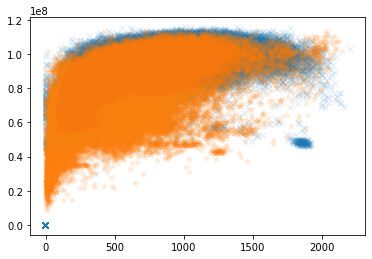

In [33]:
# Scatter plots for feature exploration

import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.scatter(ZC[0].flatten(), SV[0].flatten(), marker='x', alpha=0.1)
# ax.scatter(ZC[1].flatten(), SC[1].flatten(), marker='o', alpha=0.1)
# ax.scatter(ZC[2].flatten(), SC[2].flatten(), marker='^', alpha=0.1)
ax.scatter(ZC[3].flatten(), SV[3].flatten(), marker='*', alpha=0.1)


# ax.set_xlim(0,10000)
# ax.set_ylim(0,20000)

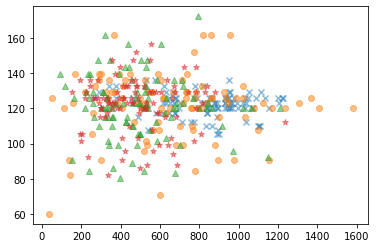

In [7]:
fig,ax = plt.subplots()
ax.scatter(np.mean(ZC[0], axis=1), staticTempo[0], marker='x', alpha=0.5)
ax.scatter(np.mean(ZC[1], axis=1), staticTempo[1], marker='o', alpha=0.5)
ax.scatter(np.mean(ZC[2], axis=1), staticTempo[2], marker='^', alpha=0.5)
ax.scatter(np.mean(ZC[3], axis=1), staticTempo[3], marker='*', alpha=0.5)


# ax.set_xlim(0,10000)
# ax.set_ylim(0,20000)

(80.0, 175.0)

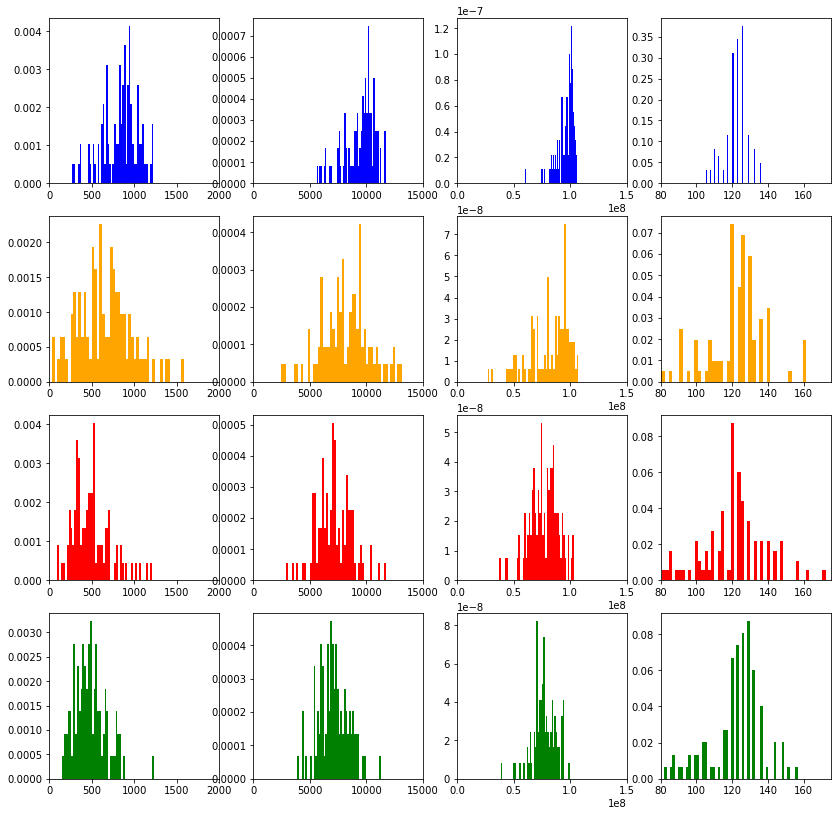

In [8]:
# From top to bottom: genre
# From left to right: zero crossings, spectral centroid, spectral variance, static tempo extimation by librosa
# For the first three the mean is taken over all windows (can be changed!)


fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12], [ax13, ax14, ax15, ax16]] = plt.subplots(4,4, figsize=(14,14))

# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3)


ax1.hist(np.mean(ZC[0], axis=1),  bins=50, density=True, color='blue')
ax2.hist(np.mean(SC[0], axis=1),  bins=50, density=True, color='blue')
ax3.hist(np.mean(SV[0], axis=1),  bins=50, density=True, color='blue')
ax4.hist(staticTempo[0] ,  bins=50, density=True, color='blue')


ax5.hist(np.mean(ZC[1], axis=1), bins=50, density=True, color='orange')
ax6.hist(np.mean(SC[1], axis=1), bins=50, density=True, color='orange')
ax7.hist(np.mean(SV[1], axis=1), bins=50, density=True, color='orange')
ax8.hist(staticTempo[1],  bins=50, density=True, color='orange')


ax9.hist(np.mean(ZC[2], axis=1),  bins=50, density=True, color='red')
ax10.hist(np.mean(SC[2], axis=1), bins=50, density=True, color='red')
ax11.hist(np.mean(SV[2], axis=1), bins=50, density=True, color='red')
ax12.hist(staticTempo[2],  bins=50, density=True, color='red')


ax13.hist(np.mean(ZC[3], axis=1), bins=50, density=True, color='green')
ax14.hist(np.mean(SC[3], axis=1), bins=50, density=True, color='green')
ax15.hist(np.mean(SV[3], axis=1), bins=50, density=True, color='green')
ax16.hist(staticTempo[3],  bins=50, density=True, color='green')


ax1.set_xlim((0,2000))
ax5.set_xlim((0,2000))
ax9.set_xlim((0,2000))
ax13.set_xlim((0,2000))

ax2.set_xlim((0,15000))
ax6.set_xlim((0,15000))
ax10.set_xlim((0,15000))
ax14.set_xlim((0,15000))

ax3.set_xlim((0,1.5e8))
ax7.set_xlim((0,1.5e8))
ax11.set_xlim((0,1.5e8))
ax15.set_xlim((0,1.5e8))

ax4.set_xlim((80,175))
ax8.set_xlim((80,175))
ax12.set_xlim((80,175))
ax16.set_xlim((80,175))

(80.0, 175.0)

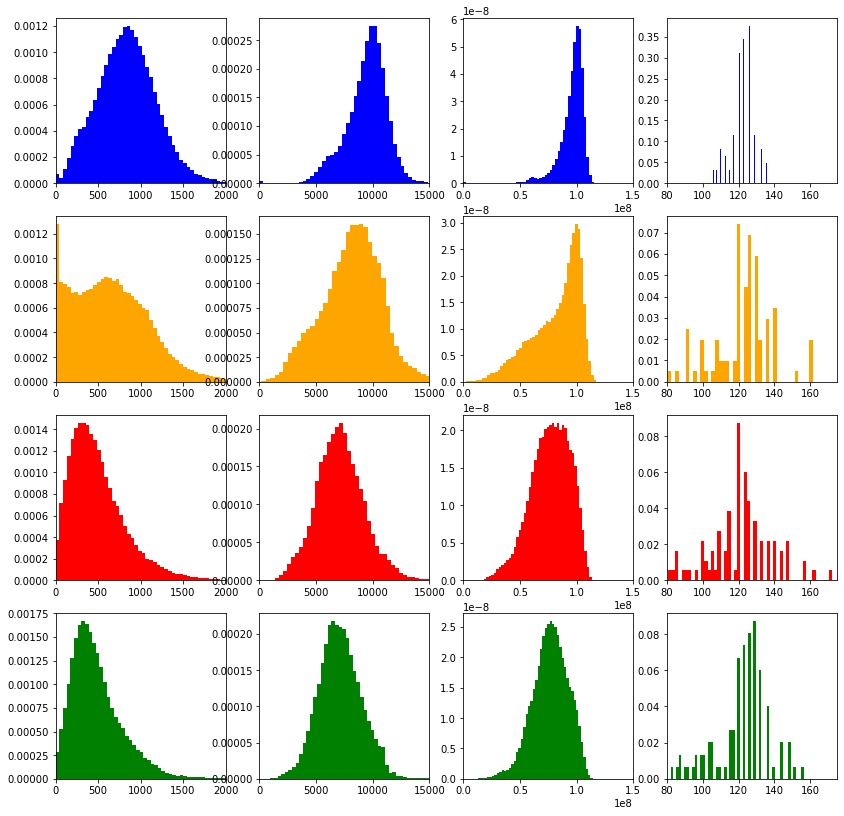

In [9]:
# From top to bottom: genre
# From left to right: zero crossings, spectral centroid, spectral variance, static tempo extimation by librosa
# No mean taken


fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12], [ax13, ax14, ax15, ax16]] = plt.subplots(4,4, figsize=(14,14))

# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3)


ax1.hist(ZC[0].flatten(),  bins=50, density=True, color='blue')
ax2.hist(SC[0].flatten(),  bins=50, density=True, color='blue')
ax3.hist(SV[0].flatten(),  bins=50, density=True, color='blue')
ax4.hist(staticTempo[0] ,  bins=50, density=True, color='blue')


ax5.hist(ZC[1].flatten(), bins=50, density=True, color='orange')
ax6.hist(SC[1].flatten(), bins=50, density=True, color='orange')
ax7.hist(SV[1].flatten(), bins=50, density=True, color='orange')
ax8.hist(staticTempo[1],  bins=50, density=True, color='orange')


ax9.hist(ZC[2].flatten(),  bins=50, density=True, color='red')
ax10.hist(SC[2].flatten(), bins=50, density=True, color='red')
ax11.hist(SV[2].flatten(), bins=50, density=True, color='red')
ax12.hist(staticTempo[2],  bins=50, density=True, color='red')


ax13.hist(ZC[3].flatten(), bins=50, density=True, color='green')
ax14.hist(SC[3].flatten(), bins=50, density=True, color='green')
ax15.hist(SV[3].flatten(), bins=50, density=True, color='green')
ax16.hist(staticTempo[3],  bins=50, density=True, color='green')


ax1.set_xlim((0,2000))
ax5.set_xlim((0,2000))
ax9.set_xlim((0,2000))
ax13.set_xlim((0,2000))

ax2.set_xlim((0,15000))
ax6.set_xlim((0,15000))
ax10.set_xlim((0,15000))
ax14.set_xlim((0,15000))

ax3.set_xlim((0,1.5e8))
ax7.set_xlim((0,1.5e8))
ax11.set_xlim((0,1.5e8))
ax15.set_xlim((0,1.5e8))

ax4.set_xlim((80,175))
ax8.set_xlim((80,175))
ax12.set_xlim((80,175))
ax16.set_xlim((80,175))

(0.0, 150000000.0)

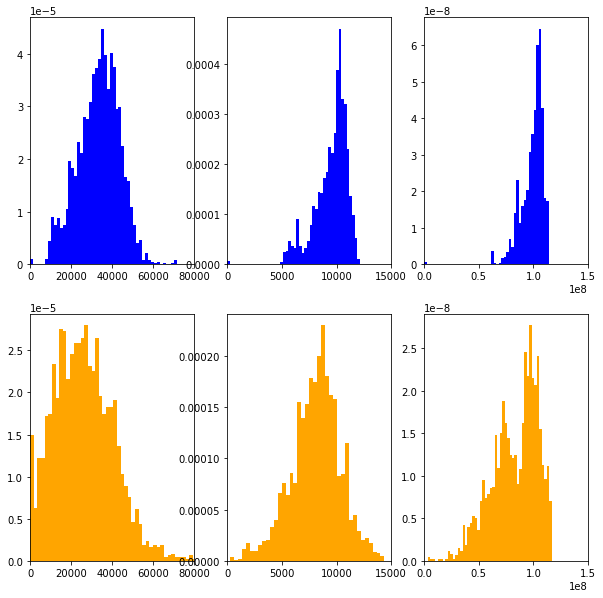

In [54]:
# fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9], [ax10, ax11, ax12]] = plt.subplots(4,3, figsize=(10,10))

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3,  figsize=(10,10))


ax1.hist(ZC_5_2[0].flatten(),  bins=50, density=True, color='blue')
ax2.hist(SC_5_2[0].flatten(),  bins=50, density=True, color='blue')
ax3.hist(SV_5_2[0].flatten(),  bins=50, density=True, color='blue')

ax4.hist(ZC_5_2[1].flatten(), bins=50, density=True, color='orange')
ax5.hist(SC_5_2[1].flatten(), bins=50, density=True, color='orange')
ax6.hist(SV_5_2[1].flatten(), bins=50, density=True, color='orange')

# ax7.hist(ZC_5_2[2].flatten(),  bins=50, density=True, color='red')
# ax8.hist(SC_5_2[2].flatten(),  bins=50, density=True, color='red')
# ax9.hist(SV_5_2[2].flatten(),  bins=50, density=True, color='red')

# ax10.hist(ZC_5_2[3].flatten(), bins=50, density=True, color='green')
# ax11.hist(SC_5_2[3].flatten(), bins=50, density=True, color='green')
# ax12.hist(SV_5_2[3].flatten(), bins=50, density=True, color='green')

ax1.set_xlim((0,80000))
ax4.set_xlim((0,80000))
ax2.set_xlim((0,15000))
ax5.set_xlim((0,15000))
ax3.set_xlim((0,1.5e8))
ax6.set_xlim((0,1.5e8))

(0.0, 150000000.0)

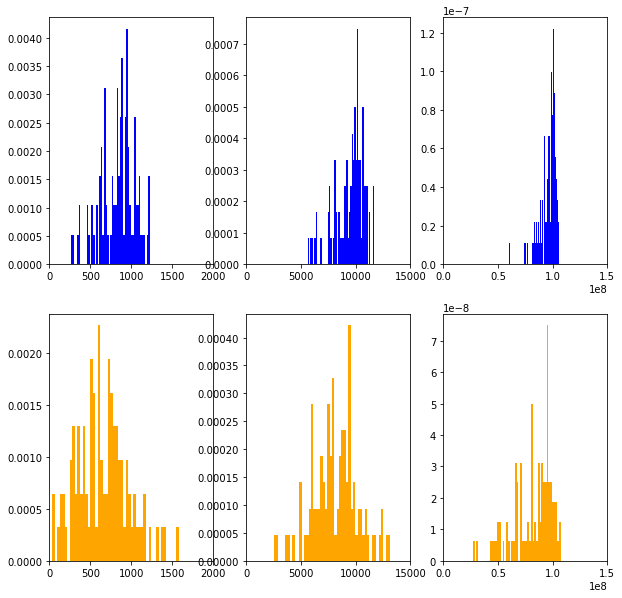

In [69]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3,  figsize=(10,10))


ZC_means0 = np.mean(ZC[0], axis=1)
ZC_means1 = np.mean(ZC[1], axis=1)

SC_means0 = np.mean(SC[0], axis=1)
SC_means1 = np.mean(SC[1], axis=1)

SV_means0 = np.mean(SV[0], axis=1)
SV_means1 = np.mean(SV[1], axis=1)


ax1.hist(ZC_means0,  bins=50, density=True, color='blue')
ax2.hist(SC_means0,  bins=50, density=True, color='blue')
ax3.hist(SV_means0,  bins=50, density=True, color='blue')

ax4.hist(ZC_means1, bins=50, density=True, color='orange')
ax5.hist(SC_means1, bins=50, density=True, color='orange')
ax6.hist(SV_means1, bins=50, density=True, color='orange')


# ax2.hist(SC[0][song,:],  bins=50, density=True, color='blue')
# ax3.hist(SV[0][song,:],  bins=50, density=True, color='blue')

# ax4.hist(ZC_means1, bins=50, density=True, color='orange')
# ax5.hist(SC[1][song,:], bins=50, density=True, color='orange')
# ax6.hist(SV[1][song,:], bins=50, density=True, color='orange')

ax1.set_xlim((0,2000))
ax4.set_xlim((0,2000))
ax2.set_xlim((0,15000))
ax5.set_xlim((0,15000))
ax3.set_xlim((0,1.5e8))
ax6.set_xlim((0,1.5e8))

--------------------------

In [40]:
# Dataframes for further feature exploration

d = {'ZC': ZC_reshape, 'SC': SC_reshape, 'SV': SV_reshape, 'StaticTempo': staticTempo_reshape}
features_dict_means = {'ZC': np.nanmean(ZC_reshape, axis=1),
           'SC': np.nanmean(SC_reshape, axis=1),
           'SV': np.nanmean(SV_reshape, axis=1),
           'StaticTempo': staticTempo_reshape}
features_df = pd.DataFrame(data=features_dict_means)
features_df

,ZC,SC,SV,StaticTempo
0,644.497496,8902.810272,9.514127e+07,126.048018
1,1199.839733,11590.207652,1.038364e+08,126.048018
2,646.835559,8996.626869,9.487061e+07,117.453835
3,931.641903,9981.106145,1.024518e+08,123.046875
4,620.358932,7563.536308,9.309474e+07,132.512019
...,...,...,...,...
395,257.477462,5361.437130,6.481753e+07,126.048018
396,271.984975,5639.261704,6.543308e+07,126.048018
397,594.792988,7931.426268,7.712652e+07,99.384014
398,413.334725,6962.836729,7.629201e+07,132.512019


In [47]:
ones = np.ones(100, dtype='int')
labels_dict = {'label': np.concatenate((ones, ones*2, ones*3, ones*4))}
labels_df = pd.DataFrame(labels_dict)
labels_df

,label
0,1
1,1
2,1
3,1
4,1
...,...
395,4
396,4
397,4
398,4


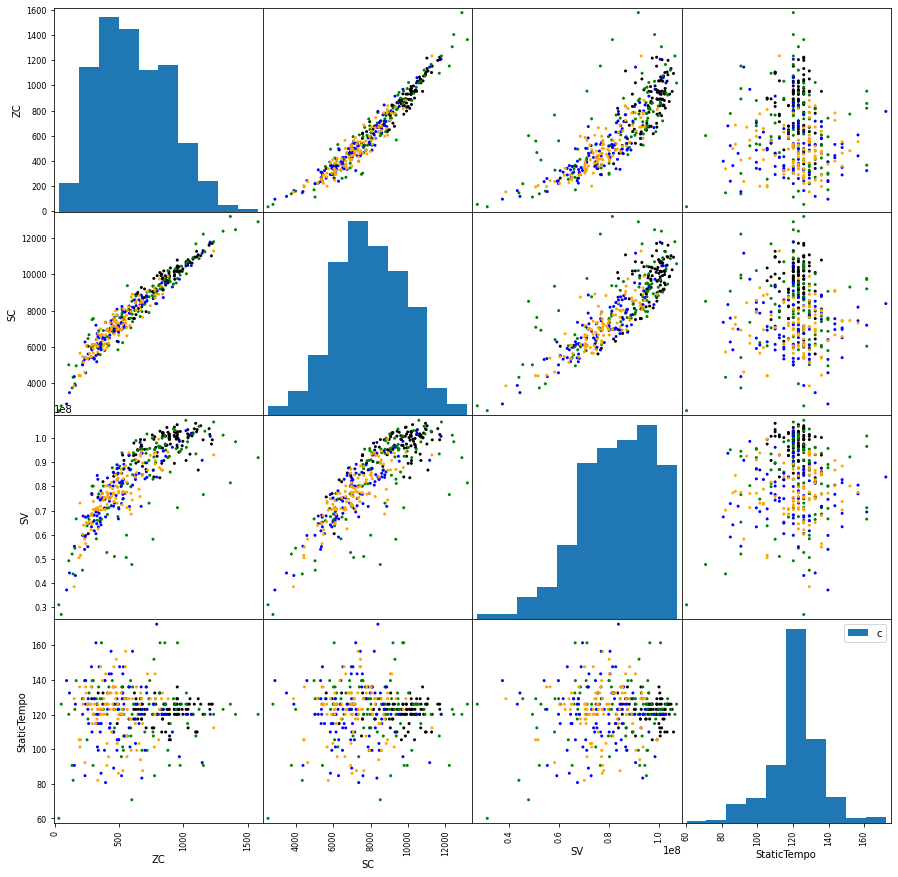

In [90]:
# All features in a scatter matrix

from matplotlib import colors
cmap = colors.ListedColormap(['k', 'g', 'b', 'orange'], 4)

F = features_df
C = labels_df.to_numpy()

pd.plotting.scatter_matrix(F, c=C, cmap=cmap, alpha=1, figsize=(15,15), diagonal = 'hist')
plt.legend('classical')

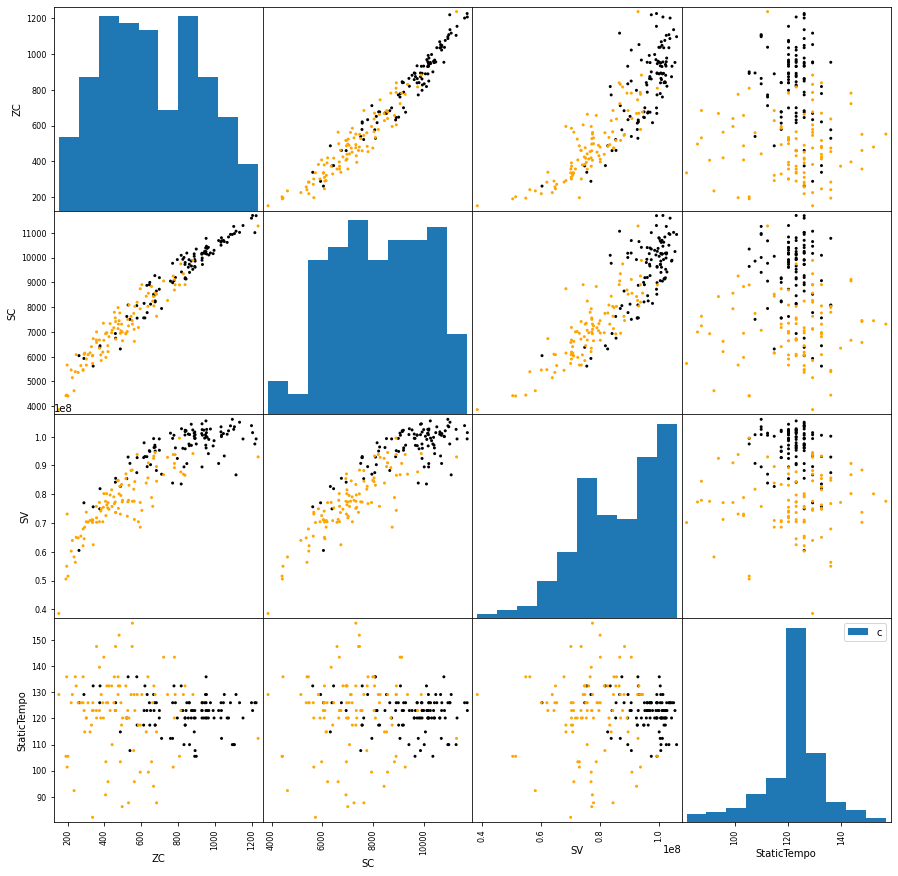

In [89]:
# All features in a scatter matrix for classical and rock. They seem seperable to some extent!!

cmap = colors.ListedColormap(['k', 'g', 'b', 'orange'], 4)

F = features_df[(labels_df['label'] == 1) | (labels_df['label'] == 4)]
C = labels_df[(labels_df['label'] == 1) | (labels_df['label'] == 4)].to_numpy()

pd.plotting.scatter_matrix(F, c=C, cmap=cmap, alpha=1, figsize=(15,15), diagonal = 'hist')
plt.legend('classical')